In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

data_path = '../Data'

AF = f'{data_path}/FinalFeatures_AF.xlsx'
DIC = f'{data_path}/FinalFeatures_DIC.xlsx'

df1 = pd.read_excel(AF, engine='openpyxl')
df2 = pd.read_excel(DIC, engine='openpyxl')

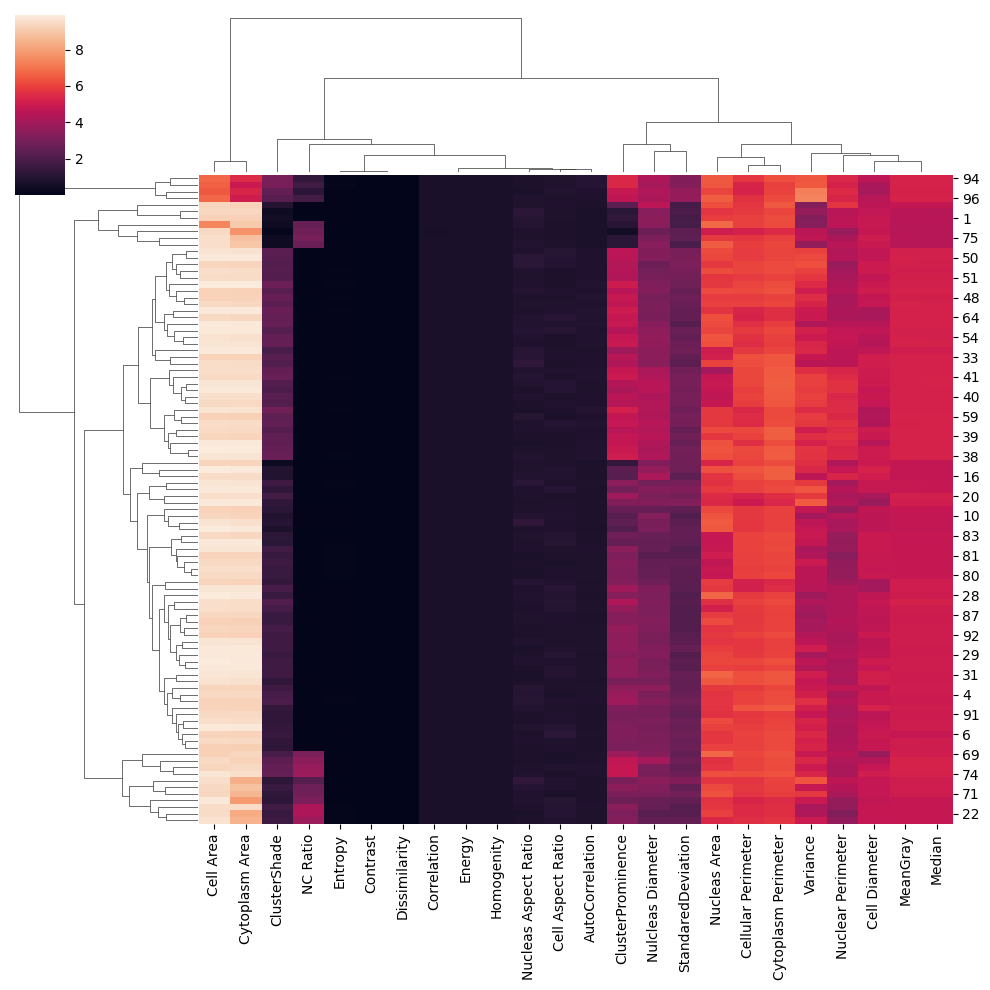

In [10]:
# Drop the 'Class' column as it's non-numerical
df1 = df1.drop(columns=['Class'])

# Check and replace infinite values
df1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values (e.g., using mean imputation)
df1.fillna(df1.mean(), inplace=True)

# Ensure all values are finite and the data types are correct
df1_numeric = df1.apply(pd.to_numeric, errors='coerce')

df1_log = np.log1p(df1_numeric)  # log1p is used to handle zeros gracefully

sns.clustermap(df1_log, method='average', metric='euclidean', figsize=(10, 10))
plt.show()


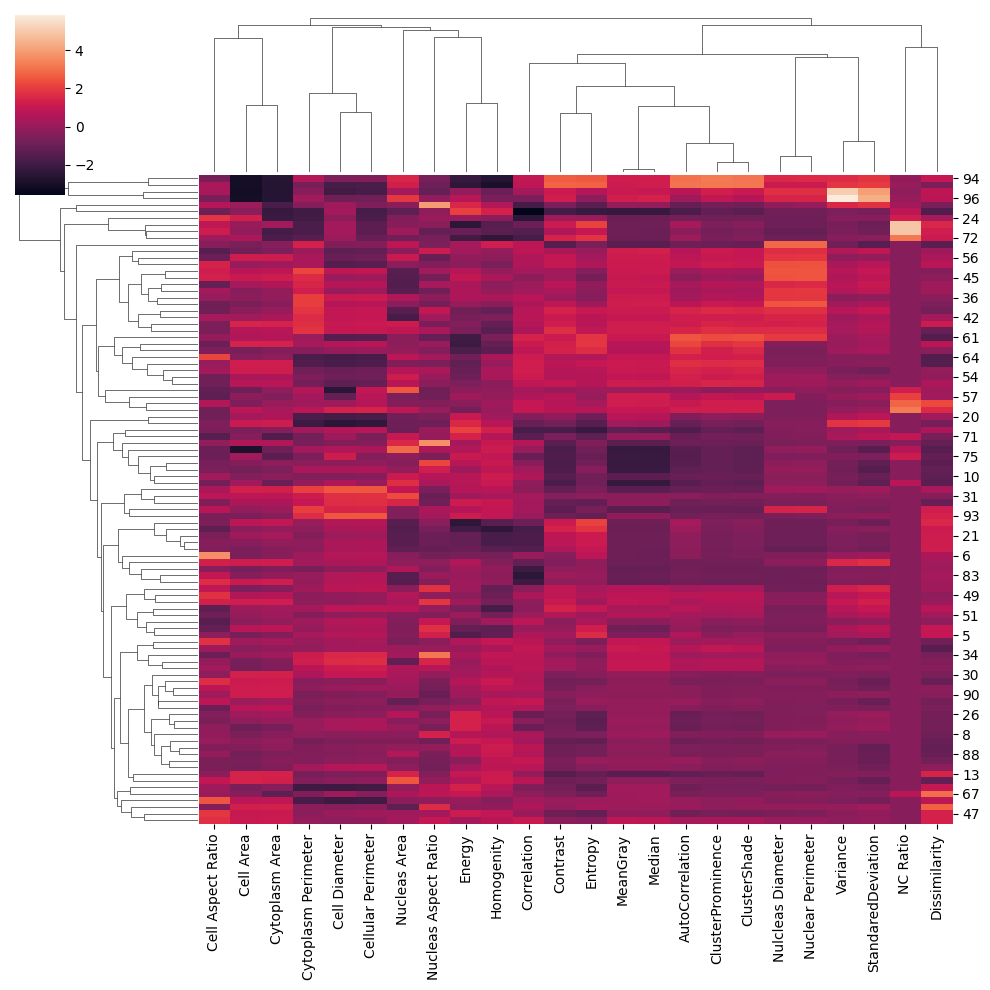

In [11]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df1_scaled = pd.DataFrame(scaler.fit_transform(df1_numeric), columns=df1_numeric.columns)

sns.clustermap(df1_scaled, method='average', metric='euclidean', figsize=(10, 10))
plt.show()

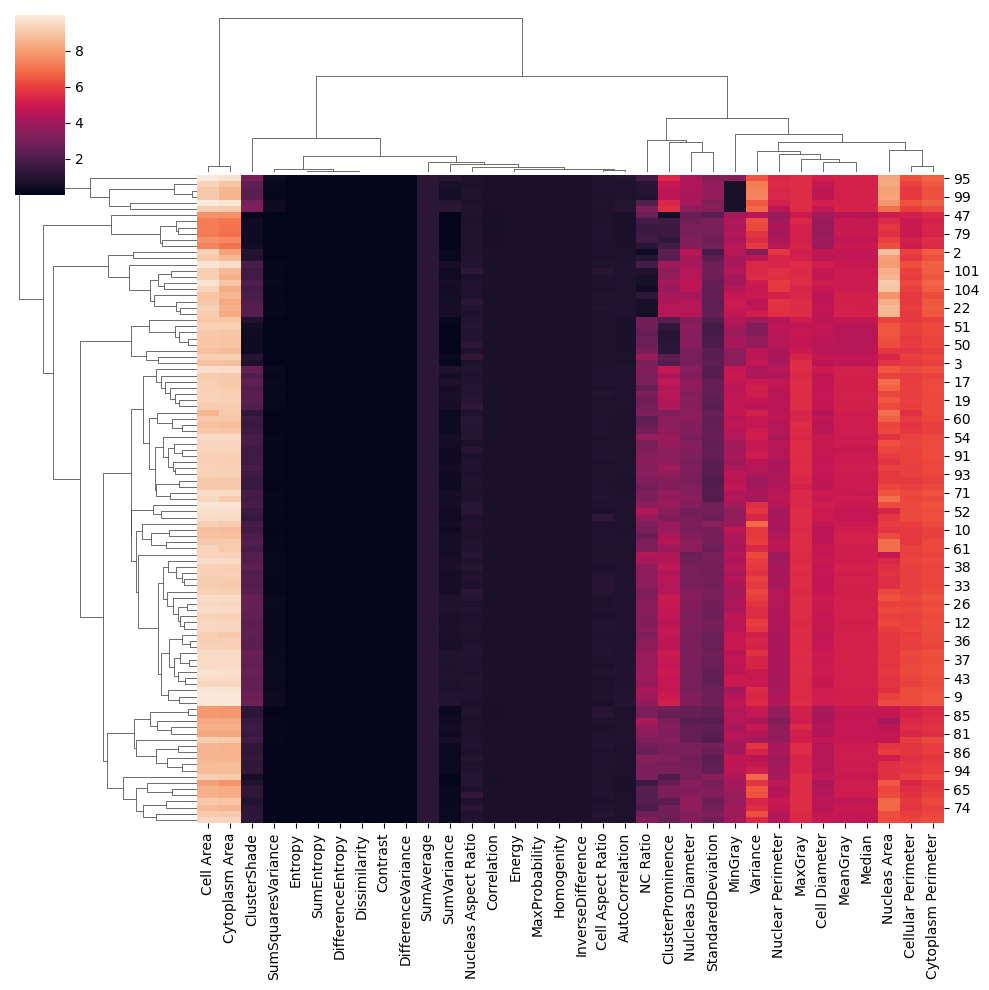

In [12]:

# Assuming df2 is already loaded

# Drop the 'Class' column as it's non-numerical
df2 = df2.drop(columns=['Class'])

# Check and replace infinite values
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values (e.g., using mean imputation)
df2.fillna(df2.mean(), inplace=True)

# Ensure all values are finite and the data types are correct
df2_numeric = df2.apply(pd.to_numeric, errors='coerce')

df2_log = np.log1p(df2_numeric)  # log1p is used to handle zeros gracefully

sns.clustermap(df2_log, method='average', metric='euclidean', figsize=(10, 10))
plt.show()


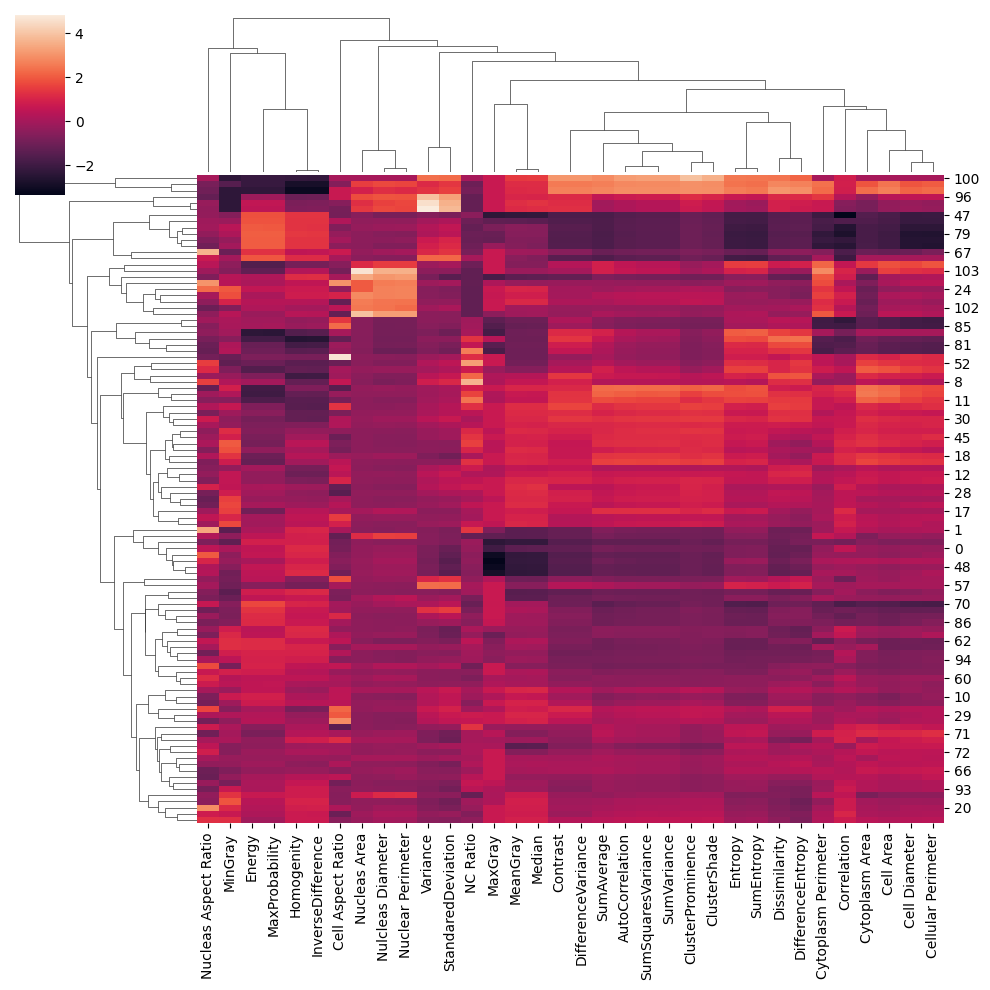

In [13]:
# Standardize the data
scaler = StandardScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df2_numeric), columns=df2_numeric.columns)

sns.clustermap(df2_scaled, method='average', metric='euclidean', figsize=(10, 10))
plt.show()

## Representing Features as Nodes in Feature Similarity Graph

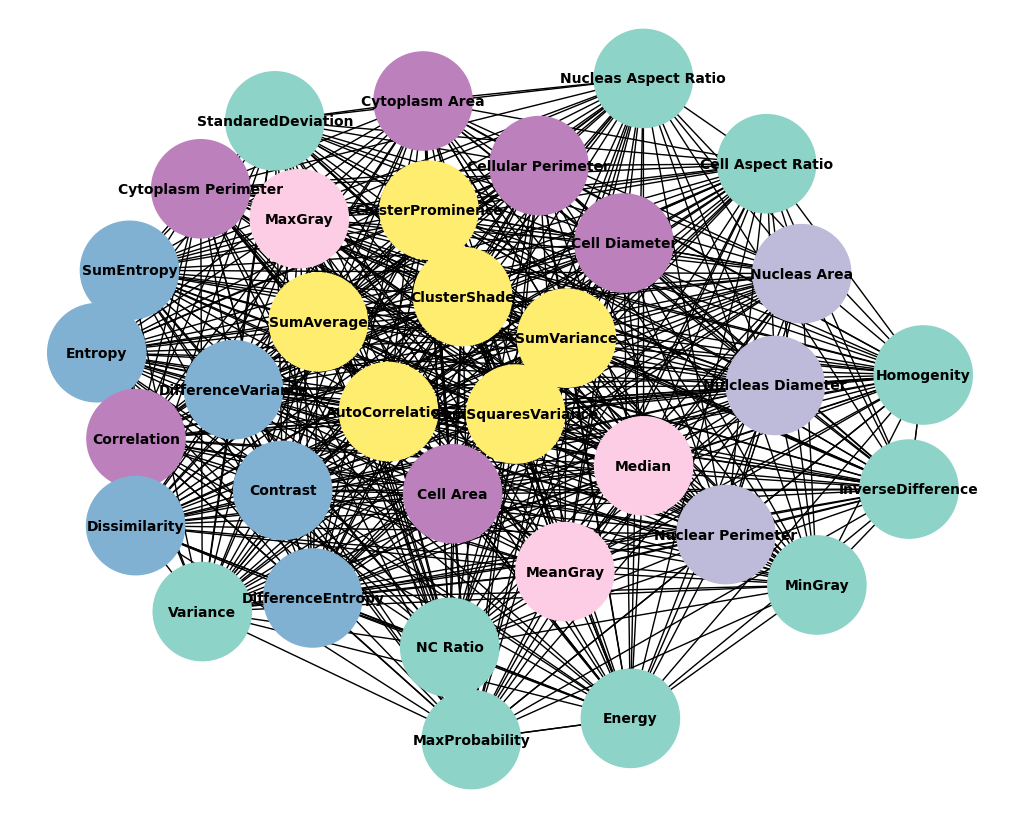

In [14]:
import community as community_louvain  # Louvain clustering
from scipy.spatial.distance import pdist, squareform

dist_matrix = pdist(df2_scaled.T, metric='euclidean')  # Pairwise distances between features (columns)
dist_matrix_square = squareform(dist_matrix)  # Convert to a square matrix

# Step 2: Convert distances to similarity
similarity_matrix = 1 / (1 + dist_matrix_square)  # Convert distances to similarities

# Step 3: Create a graph using NetworkX
G = nx.Graph()

# Add nodes (features)
for feature in df2_numeric.columns:
    G.add_node(feature)

# Add edges (with similarity as the weight)
for i, feature_1 in enumerate(df2_numeric.columns):
    for j, feature_2 in enumerate(df2_numeric.columns):
        if i < j:  # Avoid duplicate edges
            similarity = similarity_matrix[i, j]
            G.add_edge(feature_1, feature_2, weight=similarity)

# Step 4: Cluster the graph using the Louvain method
partition = community_louvain.best_partition(G)

# Step 5: Visualize the graph with clusters
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout for visualization
weights = [G[u][v]['weight'] for u, v in G.edges()]  # Extract edge weights

# Assign colors based on the clusters
colors = [partition[node] for node in G.nodes()]

# Draw the graph with clusters
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=5000, cmap=plt.cm.Set3, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=weights)

plt.show()


In [20]:
# Dictionary that maps each node (feature) to its cluster
partition = community_louvain.best_partition(G)

# Create an empty dictionary to store clusters
clusters = {}

# Group nodes by their cluster
for node, cluster in partition.items():
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(node)

# Print nodes in each cluster
for cluster_id, nodes in clusters.items():
    print(f"Cluster {cluster_id}: {nodes}")


Cluster 1: ['Cell Area', 'Cell Diameter', 'Cytoplasm Area', 'Cellular Perimeter', 'Cytoplasm Perimeter', 'Correlation']
Cluster 5: ['Cell Aspect Ratio', 'Nucleas Aspect Ratio', 'NC Ratio', 'MaxGray', 'MinGray', 'Variance', 'StandaredDeviation', 'Energy', 'Homogenity', 'InverseDifference', 'MaxProbability']
Cluster 2: ['Nucleas Area', 'Nulcleas Diameter', 'Nuclear Perimeter']
Cluster 3: ['MeanGray', 'Median']
Cluster 0: ['Contrast', 'Entropy', 'Dissimilarity', 'DifferenceVariance', 'DifferenceEntropy', 'SumEntropy']
Cluster 4: ['AutoCorrelation', 'ClusterProminence', 'ClusterShade', 'SumAverage', 'SumSquaresVariance', 'SumVariance']
